# Loading Data

In [1]:
import numpy as np
import os

def read_ops(session_data_path):
    print('Processing {}'.format(session_data_path))
    ops = np.load(
        os.path.join(session_data_path, 'ops.npy'),
        allow_pickle=True).item()
    ops['save_path0'] = os.path.join(session_data_path)
    return ops

session_data_path = 'E:\\Ph.D\\Georgia Tech\\2P\\FN16_P_20240626_js_t'
ops = read_ops(session_data_path)

Processing E:\Ph.D\Georgia Tech\2P\FN16_P_20240626_js_t


* function for loading df/f

In [2]:
import h5py

def read_dff(ops):
    """
    Reads DF/F data from an HDF5 file.

    This function opens the 'dff.h5' file located in the directory specified by ops['save_path0'],
    and extracts the DF/F data.

    Parameters:
    ops (dict): A dictionary containing operation parameters, including the 'save_path0' key
                which specifies the directory where the HDF5 file is located.

    Returns:
    np.array: An array containing the DF/F data.
    """

    f = h5py.File(os.path.join(ops['save_path0'], 'dff.h5'), 'r')
    dff = np.array(f['dff'])
    f.close()
    return dff

In [3]:
dff = read_dff(ops)
print(f'{dff.shape[0]} neurons, recorded in {dff.shape[1]/30:f} second')

197 neurons, recorded in 3584.866667 second


* defining neurons type {-1 --> excitatory, 1--> inhibitory, 0-->unsure}

In [4]:
def read_masks(ops):
    f = h5py.File(os.path.join(ops['save_path0'], 'masks.h5'), 'r')
    labels = np.array(f['labels'])
    masks = np.array(f['masks_func'])
    mean_func = np.array(f['mean_func'])
    max_func = np.array(f['max_func'])
    mean_anat = np.array(f['mean_anat']) if ops['nchannels'] == 2 else None
    masks_anat = np.array(f['masks_anat']) if ops['nchannels'] == 2 else None
    f.close()
    return [labels, masks, mean_func, max_func, mean_anat, masks_anat]


In [5]:
[labels_main, masks, mean_func, max_func, mean_anat, masks_anat] = read_masks(ops)

In [6]:
unique_labels, counts = np.unique(labels_main, return_counts=True)
label_mapping = {-1: 'excitatory', 1: 'inhibitory', 0: 'unsure'}
print(f'neuron types report within {labels_main.shape[0]}')
for label, count in zip(unique_labels, counts):
    print(f'{label_mapping[label]}: {count}')

neuron types report within 197
excitatory: 156
unsure: 9
inhibitory: 32


## Applying a filter to raw data for eliminating temporal noise

In [7]:
from scipy.signal import savgol_filter
def smooth_dff(dff, window_length=7, polyorder=3):
    """
    Apply Savitzky-Golay filter to smooth DF/F data.

    Parameters:
    dff (np.ndarray): The DF/F data to be smoothed.
    window_length (int): The length of the filter window (must be odd).
    polyorder (int): The order of the polynomial used to fit the samples.

    Returns:
    np.ndarray: The smoothed DF/F data.
    """

    # Copy the original data to avoid modifying it
    dff_smoothed = dff.copy()

    # Apply Savitzky-Golay filter to each neuron's data
    for i in range(dff.shape[0]):
        dff_smoothed[i] = savgol_filter(dff[i], window_length=window_length, polyorder=polyorder)

    return dff_smoothed

# NOTE: I am not effecting temporal structure of the data, as window lenght is so small

# Parameters
window_length = 7  # Window size (must be odd) (Larger value smoother)
polyorder = 3      # Polynomial order (lower values for smoother results)

# Apply the smoothing function
dff_filtered = smooth_dff(dff, window_length, polyorder)

# Calcium Transient Identification

In [8]:

def detect_spikes_from_dff(dff_trace, fs=30):
    """
    Detect spikes in dF/F trace using a moving window approach.
    
    Parameters:
    - dff_trace: 1D numpy array of dF/F values
    - fs: Sampling frequency (Hz)
    
    Returns:
    - spike_times: Array of spike times
    - spike_indices: Array of spike indices
    """
    # I tuned the parameters to detect spikes in the data (85th percentile, and 15 points around peak)
    
    # Calculate 85th percentile
    percentile_85 = np.percentile(dff_trace, 85)
    
    # Number of points around peak
    n_points = 15
    
    # Calculate the area under this window as a threshold  
    gaussian_area = percentile_85*n_points
    
    # Window for spike detection
    window_size = n_points
    
    # Detect spikes (I am using nan between as I will use nan values as a dectector in future steps)
    spike_indices = np.full(len(dff_trace), np.nan)
    
    for i in range(len(dff_trace) - window_size + 1):
        # Extract window
        window = dff_trace[i:i+window_size]
        
        # Calculate area of this window
        window_area = np.sum(window)
        
        # Compare areas
        if window_area > gaussian_area:
            spike_indices[i + window_size//5] = i + window_size//5
    
    # Convert indices to times
    spike_times = np.where(~np.isnan(spike_indices))[0] / fs
    
    return spike_times, spike_indices, gaussian_area

* Applying function <br>
We discussed on moving whole dff based on 30 perceintile of dff, but as it effects the "Area" analysis I am not going to use

In [9]:
from tqdm import tqdm

time = np.linspace(0,dff_filtered.shape[1]/30,dff_filtered.shape[1])

all_spike_times = []
all_spike_indices = []

for i in tqdm(range(dff_filtered.shape[0])):
    spike_times, spike_indices, _ = detect_spikes_from_dff(dff_filtered[i])
    all_spike_times.append(spike_times)
    all_spike_indices.append(spike_indices)

  0%|          | 0/197 [00:00<?, ?it/s]

100%|██████████| 197/197 [01:23<00:00,  2.37it/s]


* Use this cell for interactive plotting for what neuron desired

In [10]:
from matplotlib import pyplot as plt
%matplotlib qt

neuron = 4

# Visualize
plt.figure(figsize=(15, 6))
plt.plot(time, dff_filtered[neuron], label='dF/F Trace')
# plt.plot(time, dff_filtered[4], label='dF/F Trace')
# Plot only the non-NaN spike points
valid_spike_indices = ~np.isnan(all_spike_indices[neuron])
plt.scatter(time[valid_spike_indices], dff_filtered[neuron][valid_spike_indices], color='red', label='Detected Spikes')

plt.xlabel('Time (s)')
plt.ylabel('dF/F')
plt.title(f'Spike Detection in dF/F Trace for Neuron {neuron}')
plt.legend()
plt.show()

# Print spike information
print(f"Number of spikes detected: {len(spike_times)}")
print("Spike times (s):", spike_times)

Number of spikes detected: 7447
Spike times (s): [1.00000000e-01 1.33333333e-01 1.66666667e-01 ... 3.57740000e+03
 3.57743333e+03 3.57746667e+03]


* Seperating Calcium transient


In [11]:
def group_spikes(spike_indices):
    """
    Group continuous spike indices, ignoring NaN values
    
    Parameters:
    - spike_indices: Array with spike indices and NaN values
    
    Returns:
    - List of lists containing grouped spike indices
    """
    # Find indices of non-NaN values
    valid_spikes = ~np.isnan(spike_indices)
    
    # Find the indices where the boolean array changes
    changes = np.diff(valid_spikes.astype(int))
    
    # Find start and end of each group
    group_starts = np.where(changes == 1)[0] + 1
    group_ends = np.where(changes == -1)[0] + 1
    
    # Handle edge cases
    if valid_spikes[0]:
        group_starts = np.insert(group_starts, 0, 0)
    if valid_spikes[-1]:
        group_ends = np.append(group_ends, len(spike_indices))
    
    # Extract groups
    spike_groups = []
    for start, end in zip(group_starts, group_ends):
        # Get indices of spikes in this group
        group = np.where(~np.isnan(spike_indices[start:end]))[0] + start
        spike_groups.append(group.tolist())
    
    return spike_groups


In [12]:
all_calcium_tran = []

for i in tqdm(range(len(all_spike_indices))):
    all_calcium_tran.append(group_spikes(all_spike_indices[i]))

100%|██████████| 197/197 [00:00<00:00, 240.05it/s]


## Using statistical check for removing outlayer Calcium Tran

In [13]:
# Define the different k values
k_values = {'strict': 0.01, 'medium': 0.1, 'relaxed': 0.5}

# Initialize the dictionary to store results
results = {}

# Iterate over all neurons
for neuron_index in range(len(all_calcium_tran)):
    groups_1 = all_calcium_tran[neuron_index][1:-1]
    lengths = [len(lst) for lst in groups_1]
    mean_length = np.mean(lengths)
    std_length = np.std(lengths)
    
    # Initialize the dictionary for this neuron
    results[neuron_index] = {'initial_length': len(groups_1)}
    
    # Apply the statistical check for each k value
    for k_name, k in k_values.items():
        filtered_lists = [lst for lst in groups_1 if len(lst) >= mean_length - k * std_length]
        results[neuron_index][f'{k_name}_filtered_length'] = len(filtered_lists)
        results[neuron_index][f'{k_name}_filtered_lists'] = filtered_lists
        results[neuron_index][f'{k_name}_filtered_length'] = len(filtered_lists)

* Checking results

In [30]:
# Define neuron and filter type
neuron = 4
filter_type = 'strict'  # Choose from 'strict', 'medium', 'relaxed'

# Visualize
plt.figure(figsize=(15, 6))
plt.plot(time, dff_filtered[neuron], label='dF/F Trace')

# Plot only the non-NaN spike points
valid_spike_indices = ~np.isnan(all_spike_indices[neuron])
plt.scatter(time[valid_spike_indices], dff_filtered[neuron][valid_spike_indices], color='red', label='Detected transient')

# Flatten the list based on the chosen filter type
flattened_list = [item for sublist in results[neuron][f'{filter_type}_filtered_lists'] for item in sublist]

plt.scatter(time[flattened_list], dff_filtered[neuron][flattened_list], color='yellow', marker='x', label='Better transient')

plt.xlabel('Time (s)')
plt.ylabel('dF/F')
plt.title(f'Spike Detection in dF/F Trace: initial count {results[neuron]["initial_length"]} and better transient count {results[neuron][f"{filter_type}_filtered_length"]}')
plt.legend()
plt.show()


## Calculating calcium transient area

In [15]:
def area(dff_trace, spike_groups):
    """
    Finidng area of each Idendified calcium transient
    
    Parameters:
    - dff_trace: Original dF/F trace
    - spike_groups: List of spike groups (indices) // this can be filtered 
    
    Returns:
    - aligned_segments: List of aligned and padded segments
    - first_indices: First indices of each group
    """
    # Area
    area_segments = []
    
    for group in spike_groups:
        
        # Fill segment with original dF/F values
        area = np.sum(np.abs(dff_trace[group]))
        
        area_segments.append(area)
    
    return area_segments


In [35]:
for neuron_index in results.keys():
    for filter_type in ['strict', 'medium', 'relaxed']:
        spike_groups = results[neuron_index][f'{filter_type}_filtered_lists']
        dff_trace = dff_filtered[neuron_index]
        area_segments = area(dff_trace, spike_groups)
        results[neuron_index][f'{filter_type}_area_segments'] = area_segments
        # Peak vlaue
        results[neuron_index][f'{filter_type}_peak_segments'] = [np.max(dff_trace[group]) for group in spike_groups]
        # Peak time
        results[neuron_index][f'{filter_type}_peak_time'] = [np.argmax(dff_trace[group]) for group in spike_groups]


* boxplot for area

In [52]:
# Extract area segments for the specified neuron and filter types
neuron = 2
filter_types = ['relaxed', 'medium', 'strict']
area_segments = [results[neuron][f'{filter_type}_area_segments'] for filter_type in filter_types]

# Create a violin plot with quartiles and mean
plt.figure(figsize=(12, 6))
parts = plt.violinplot(area_segments, showmeans=True, showmedians=True)

# Customize violin plot colors
parts['cmeans'].set_color('orange')    # Set mean color
parts['cmedians'].set_color('purple')  # Set median color

# Adding box for quartiles
for i in range(len(area_segments)):
    q1, q3 = np.percentile(area_segments[i], [25, 75])
    plt.plot([i + 1, i + 1], [q1, q3], color='green', lw=5)

# Create x-tick labels with counts
x_labels = [f'{filter_type}\n(n={len(data)})' for filter_type, data in zip(filter_types, area_segments)]
plt.xticks([1, 2, 3], x_labels)

plt.xlabel('Filter Type')
plt.ylabel('Calcium Transient Area')
plt.title(f'Violin Plot of Calcium Transient Area for Neuron {neuron}')

# Adding legend
handles = [
    plt.Line2D([0], [0], color='orange', lw=2, label='Mean'),
    plt.Line2D([0], [0], color='purple', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=5, label='Quartiles')
]
plt.legend(handles=handles)

plt.show()

## Aligning all Identified Calcium Tran

In [36]:
def align_spike_segments(dff_trace, spike_groups, left_frames=0, right_frames=0):
    """
    Align spike segments based on the first index of each group and pad with dF/F values,
    then add extra frames to the left and right of each segment.

    Parameters:
    - dff_trace: Original dF/F trace
    - spike_groups: List of spike groups (indices)
    - left_frames: Number of frames to add on the left of each segment
    - right_frames: Number of frames to add on the right of each segment

    Returns:
    - aligned_segments: List of aligned and padded segments
    - first_indices: First indices of each group
    """
    # Determine the size of the largest segment and calculate padding
    segment_lengths = [len(group) for group in spike_groups]
    max_segment_length = max(segment_lengths)
    total_length = max_segment_length + left_frames + right_frames  # Total length after adding frames

    # Align and pad segments
    aligned_segments = []
    first_indices = []

    for group in spike_groups:
        # Start index for the padded segment
        start_index = max(group[0] - left_frames, 0)
        # End index for the padded segment
        end_index = min(group[-1] + right_frames + 1, len(dff_trace))  # +1 to include the last value

        # Extract the padded segment from dff_trace
        segment = dff_trace[start_index:end_index]

        # If the segment is shorter than the total length, pad with edge values
        if len(segment) < total_length:
            segment = np.pad(
                segment, 
                (0, total_length - len(segment)), 
                mode='edge'
            )

        aligned_segments.append(segment[:total_length])  # Ensure it's exactly the total length
        first_indices.append(group[0])  # Keep track of the original first index

    return aligned_segments, first_indices

In [102]:
def calculate_half_decay_time(segments, peak_values, peak_indices, left_frames, sampling_rate=30):
    """
    Calculate the half decay time of a given segment.

    Parameters:
    segments (np.ndarray): The aligned segments data.
    peak_values (np.ndarray): The peak values of each segment calculated before alingment.
    sampling_rate (int): The sampling rate in Hz. Default is 30.

    Returns:
    half_decay_time (np. ndarray): The half decay time in seconds.
    """
    
    # Find the index of the maximum value
    max_index = peak_indices + left_frames
    
    # Calculate the half maximum value
    half_max_value = peak_values / 2
    
    # Find the index where the segment falls below the half maximum value after the peak
    half_max_index = []
    for segment, max_idx, half_max_val in zip(segments, max_index, half_max_value):
        indices = np.where(segment[max_idx:] <= half_max_val)[0]
        if len(indices) > 0:
            half_max_index.append(indices[0])
        else:
            half_max_index.append(np.nan)  # or handle this case as needed

    half_max_index = np.array(half_max_index)
    
    # Calculate the half decay time in seconds
    half_decay_time = half_max_index / sampling_rate
    
    return half_decay_time

In [103]:
left_frames = 30
right_frames = 30

for neuron_index in results.keys():
    for filter_type in ['strict', 'medium', 'relaxed']:
        spike_groups = results[neuron_index][f'{filter_type}_filtered_lists']
        dff_trace = dff_filtered[neuron_index]
        aligned_segments, first_indices = align_spike_segments(dff_trace, spike_groups, left_frames, right_frames)
        results[neuron_index][f'{filter_type}_aligned_segments'] = aligned_segments
        results[neuron_index][f'{filter_type}_average_segment'] = np.nanmean(aligned_segments, axis=0)
        results[neuron_index][f'{filter_type}_half_decay'] = calculate_half_decay_time(np.array(aligned_segments), 
                                                                                       np.array(results[neuron_index][f'{filter_type}_peak_segments']), 
                                                                                       np.array(results[neuron_index][f'{filter_type}_peak_time']), 
                                                                                       left_frames)
        results[neuron_index][f'{filter_type}_time_peak_segment'] = [time / 30 for time in results[neuron_index][f'{filter_type}_peak_time']]
        results[neuron_index][f'{filter_type}_sem_segment'] = np.nanstd(aligned_segments, axis=0) / np.sqrt(len(aligned_segments))
        results[neuron_index][f'{filter_type}_first_indices'] = first_indices


* plotting Average and sgments

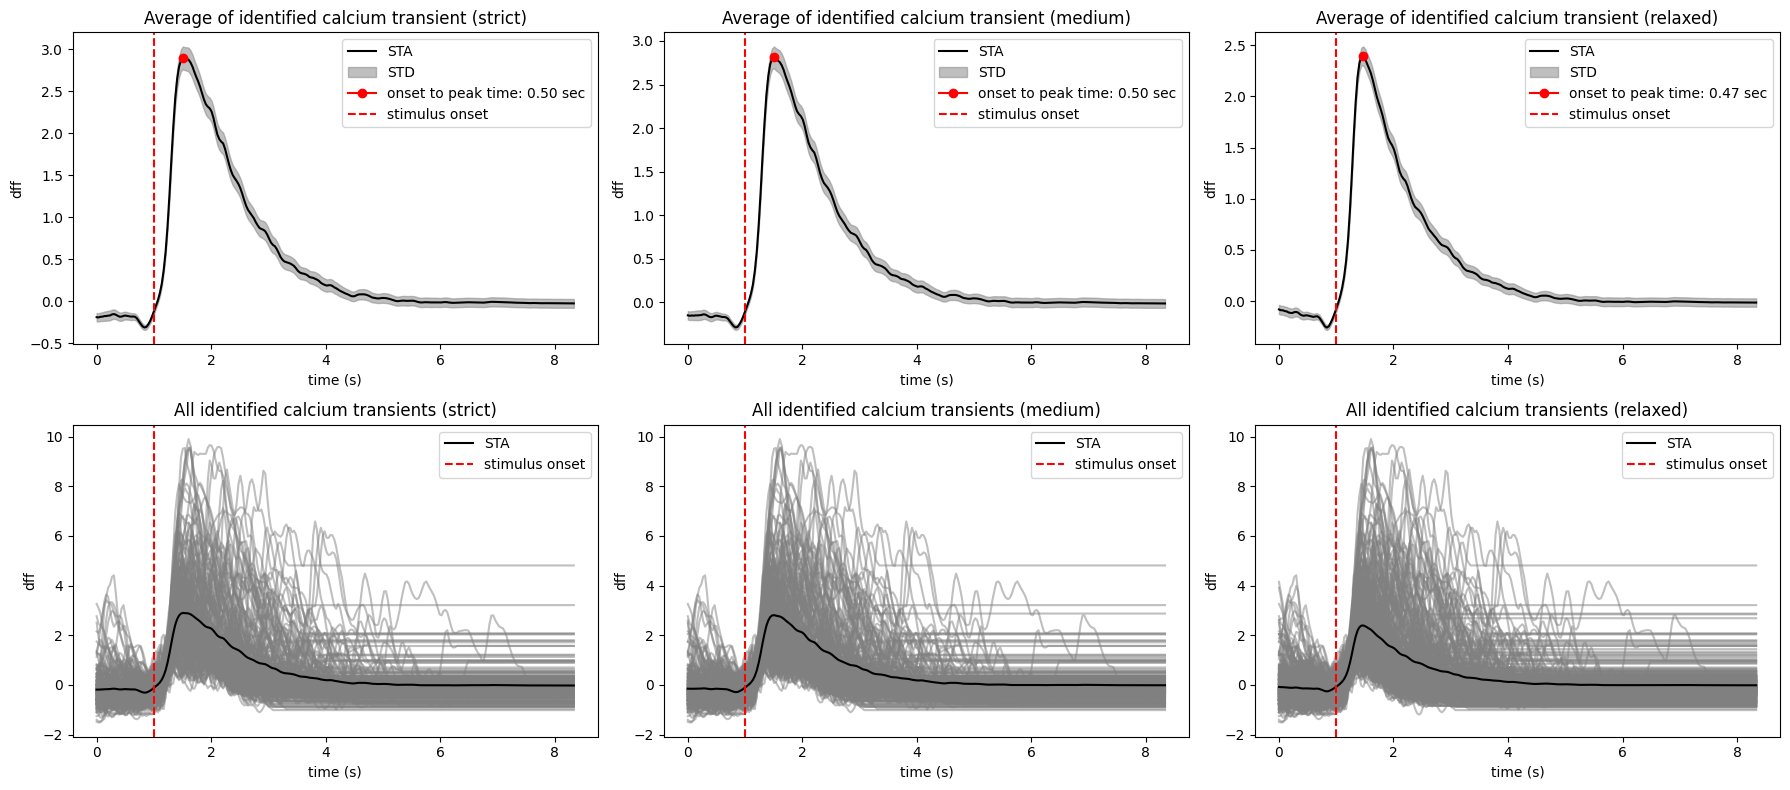

In [104]:
%matplotlib inline

neuron = 20
filter_types = ['strict', 'medium', 'relaxed']

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i, filter_type in enumerate(filter_types):
    average_segment = results[neuron][f'{filter_type}_average_segment']
    std_segment = results[neuron][f'{filter_type}_sem_segment']
    aligned_segments = results[neuron][f'{filter_type}_aligned_segments']
    filtered_lists = results[neuron][f'{filter_type}_filtered_lists']

    tim_sta = np.linspace(0, average_segment.shape[0]/30, average_segment.shape[0])

    # Time to peak
    peak_time = np.argmax(average_segment)
    # Time to peak in seconds
    peak_time_s = (peak_time - left_frames) / 30

    # Plot average segment
    axs[0, i].plot(tim_sta, average_segment, color='k', label='STA')
    axs[0, i].fill_between(tim_sta, average_segment - std_segment, average_segment + std_segment, color='gray', alpha=0.5, label='STD')
    axs[0, i].plot(tim_sta[peak_time], average_segment[peak_time], marker='o', color='r', label=f'onset to peak time: {peak_time_s:.2f} sec')
    axs[0, i].axvline(x=left_frames/30, color='r', linestyle='--', label='stimulus onset')
    axs[0, i].set_xlabel('time (s)')
    axs[0, i].set_ylabel('dff')
    axs[0, i].legend()
    axs[0, i].set_title(f'Average of identified calcium transient ({filter_type})')

    # Plot all segments
    for segment in aligned_segments:
        axs[1, i].plot(tim_sta, segment, color='gray', alpha=0.5)
    axs[1, i].plot(tim_sta, average_segment, color='k', label='STA')
    axs[1, i].axvline(x=left_frames/30, color='r', linestyle='--', label='stimulus onset')
    axs[1, i].set_xlabel('time (s)')
    axs[1, i].set_ylabel('dff')
    axs[1, i].legend()
    axs[1, i].set_title(f'All identified calcium transients ({filter_type})')

plt.tight_layout()
plt.show()

## Saving all neuron and all types analysis result

In [105]:
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

# Define the PDF file name
pdf_file_name = 'calcium_transient_analysis.pdf'

# Create a PdfPages object
with PdfPages(pdf_file_name) as pdf:
    # Iterate over all neurons
    for neuron_index in tqdm(range(len(labels_main))):
        neuron_type = label_mapping[labels_main[neuron_index]]
        
        # Create a new figure for each neuron
        fig, axs = plt.subplots(3, 3, figsize=(24, 18))
        fig.suptitle(f'Neuron {neuron_index} - Type: {neuron_type}', fontsize=16)
        
        filter_types = ['relaxed', 'medium', 'strict']
        
        for i, filter_type in enumerate(filter_types):
            # Extract area segments for the specified neuron and filter types
            area_segments = results[neuron_index][f'{filter_type}_area_segments']
            
            # Plot violin plot for area segments
            parts = axs[0, i].violinplot(area_segments, showmeans=True, showmedians=True)
            
            # Customize violin plot colors
            parts['cmeans'].set_color('orange')    # Set mean color
            parts['cmedians'].set_color('purple')  # Set median color

            # Adding box for quartiles
            q1, q3 = np.percentile(area_segments, [25, 75])
            axs[0, i].plot([1, 1], [q1, q3], color='green', lw=5)

            axs[0, i].set_title(f'Area Segments ({filter_type})')
            axs[0, i].set_xlabel('Filter Type')
            axs[0, i].set_ylabel('Calcium Transient Area')
            axs[0, i].set_xticks([1])
            axs[0, i].set_xticklabels([filter_type])
            
            # Report the number of initial_length and after applying filter
            initial_length = results[neuron_index]['initial_length']
            filtered_length = results[neuron_index][f'{filter_type}_filtered_length']
            axs[0, i].text(0.5, 0.95, f'Initial: {initial_length}\nFiltered: {filtered_length}', 
                           transform=axs[0, i].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
            
            axs[0, i].spines['top'].set_visible(False)
            axs[0, i].spines['right'].set_visible(False)
            
            # Plot average segment
            average_segment = results[neuron_index][f'{filter_type}_average_segment']
            std_segment = results[neuron_index][f'{filter_type}_sem_segment']
            tim_sta = np.linspace(0, average_segment.shape[0]/30, average_segment.shape[0])
            
            peak_time = np.argmax(average_segment)
            peak_time_s = (peak_time - left_frames) / 30
            
            axs[1, i].plot(tim_sta, average_segment, color='k', label='STA')
            axs[1, i].fill_between(tim_sta, average_segment - std_segment, average_segment + std_segment, color='gray', alpha=0.5, label='STD')
            axs[1, i].plot(tim_sta[peak_time], average_segment[peak_time], marker='o', color='r', label=f'onset to peak time: {peak_time_s:.2f} sec')
            axs[1, i].axvline(x=left_frames/30, color='r', linestyle='--', label='Calcium_transient onset')
            axs[1, i].set_xlabel('time (s)')
            axs[1, i].set_ylabel('dff')
            axs[1, i].legend()
            axs[1, i].set_title(f'Average of identified calcium transient ({filter_type})')
            axs[1, i].spines['top'].set_visible(False)
            axs[1, i].spines['right'].set_visible(False)
            
            # Plot all segments
            aligned_segments = results[neuron_index][f'{filter_type}_aligned_segments']
            for segment in aligned_segments:
                axs[2, i].plot(tim_sta, segment, color='gray', alpha=0.5)
            axs[2, i].plot(tim_sta, average_segment, color='k', label='STA')
            axs[2, i].axvline(x=left_frames/30, color='k', linestyle='--', label='Calcium_transient onset')
            axs[2, i].set_xlabel('time (s)')
            axs[2, i].set_ylabel('dff')
            axs[2, i].legend()
            axs[2, i].set_title(f'All identified calcium transients ({filter_type})')
            axs[2, i].spines['top'].set_visible(False)
            axs[2, i].spines['right'].set_visible(False)
        
        # Adjust layout and save the figure to the PDF
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

100%|██████████| 197/197 [08:05<00:00,  2.46s/it]


## Pooled all segments

In [ ]:
# Initialize lists to store pooled data for excitatory neurons
Exc_all_areas_strict = []
Exc_all_peaks_strict = []
Exc_all_decay_times_strict = []
Exc_all_segments_strict = []
Exc_all_time_peak_segments_strict = []

Exc_all_areas_medium = []
Exc_all_peaks_medium = []
Exc_all_decay_times_medium = []
Exc_all_segments_medium = []
Exc_all_time_peak_segments_medium = []

Exc_all_areas_relaxed = []
Exc_all_peaks_relaxed = []
Exc_all_decay_times_relaxed = []
Exc_all_segments_relaxed = []
Exc_all_time_peak_segments_relaxed = []

# Initialize lists to store pooled data for inhibitory neurons
Inh_all_areas_strict = []
Inh_all_peaks_strict = []
Inh_all_decay_times_strict = []
Inh_all_segments_strict = []
Inh_all_time_peak_segments_strict = []

Inh_all_areas_medium = []
Inh_all_peaks_medium = []
Inh_all_decay_times_medium = []
Inh_all_segments_medium = []
Inh_all_time_peak_segments_medium = []

Inh_all_areas_relaxed = []
Inh_all_peaks_relaxed = []
Inh_all_decay_times_relaxed = []
Inh_all_segments_relaxed = []
Inh_all_time_peak_segments_relaxed = []

# Iterate through the results and pool the data for each neuron type
for neuron_index in results.keys():
    if labels_main[neuron_index] == -1:  # Check if the neuron is excitatory
        Exc_all_areas_strict.append(results[neuron_index]['strict_area_segments'])
        Exc_all_peaks_strict.append(results[neuron_index]['strict_peak_segments'])
        Exc_all_decay_times_strict.append(results[neuron_index]['strict_half_decay'])
        Exc_all_segments_strict.append(results[neuron_index]['strict_aligned_segments'])
        Exc_all_time_peak_segments_strict.append(results[neuron_index]['strict_time_peak_segment'])

        Exc_all_areas_medium.append(results[neuron_index]['medium_area_segments'])
        Exc_all_peaks_medium.append(results[neuron_index]['medium_peak_segments'])
        Exc_all_decay_times_medium.append(results[neuron_index]['medium_half_decay'])
        Exc_all_segments_medium.append(results[neuron_index]['medium_aligned_segments'])
        Exc_all_time_peak_segments_medium.append(results[neuron_index]['medium_time_peak_segment'])

        Exc_all_areas_relaxed.append(results[neuron_index]['relaxed_area_segments'])
        Exc_all_peaks_relaxed.append(results[neuron_index]['relaxed_peak_segments'])
        Exc_all_decay_times_relaxed.append(results[neuron_index]['relaxed_half_decay'])
        Exc_all_segments_relaxed.append(results[neuron_index]['relaxed_aligned_segments'])
        Exc_all_time_peak_segments_relaxed.append(results[neuron_index]['relaxed_time_peak_segment'])
    elif labels_main[neuron_index] == 1:  # Check if the neuron is inhibitory
        Inh_all_areas_strict.append(results[neuron_index]['strict_area_segments'])
        Inh_all_peaks_strict.append(results[neuron_index]['strict_peak_segments'])
        Inh_all_decay_times_strict.append(results[neuron_index]['strict_half_decay'])
        Inh_all_segments_strict.append(results[neuron_index]['strict_aligned_segments'])
        Inh_all_time_peak_segments_strict.append(results[neuron_index]['strict_time_peak_segment'])

        Inh_all_areas_medium.append(results[neuron_index]['medium_area_segments'])
        Inh_all_peaks_medium.append(results[neuron_index]['medium_peak_segments'])
        Inh_all_decay_times_medium.append(results[neuron_index]['medium_half_decay'])
        Inh_all_segments_medium.append(results[neuron_index]['medium_aligned_segments'])
        Inh_all_time_peak_segments_medium.append(results[neuron_index]['medium_time_peak_segment'])

        Inh_all_areas_relaxed.append(results[neuron_index]['relaxed_area_segments'])
        Inh_all_peaks_relaxed.append(results[neuron_index]['relaxed_peak_segments'])
        Inh_all_decay_times_relaxed.append(results[neuron_index]['relaxed_half_decay'])
        Inh_all_segments_relaxed.append(results[neuron_index]['relaxed_aligned_segments'])
        Inh_all_time_peak_segments_relaxed.append(results[neuron_index]['relaxed_time_peak_segment'])

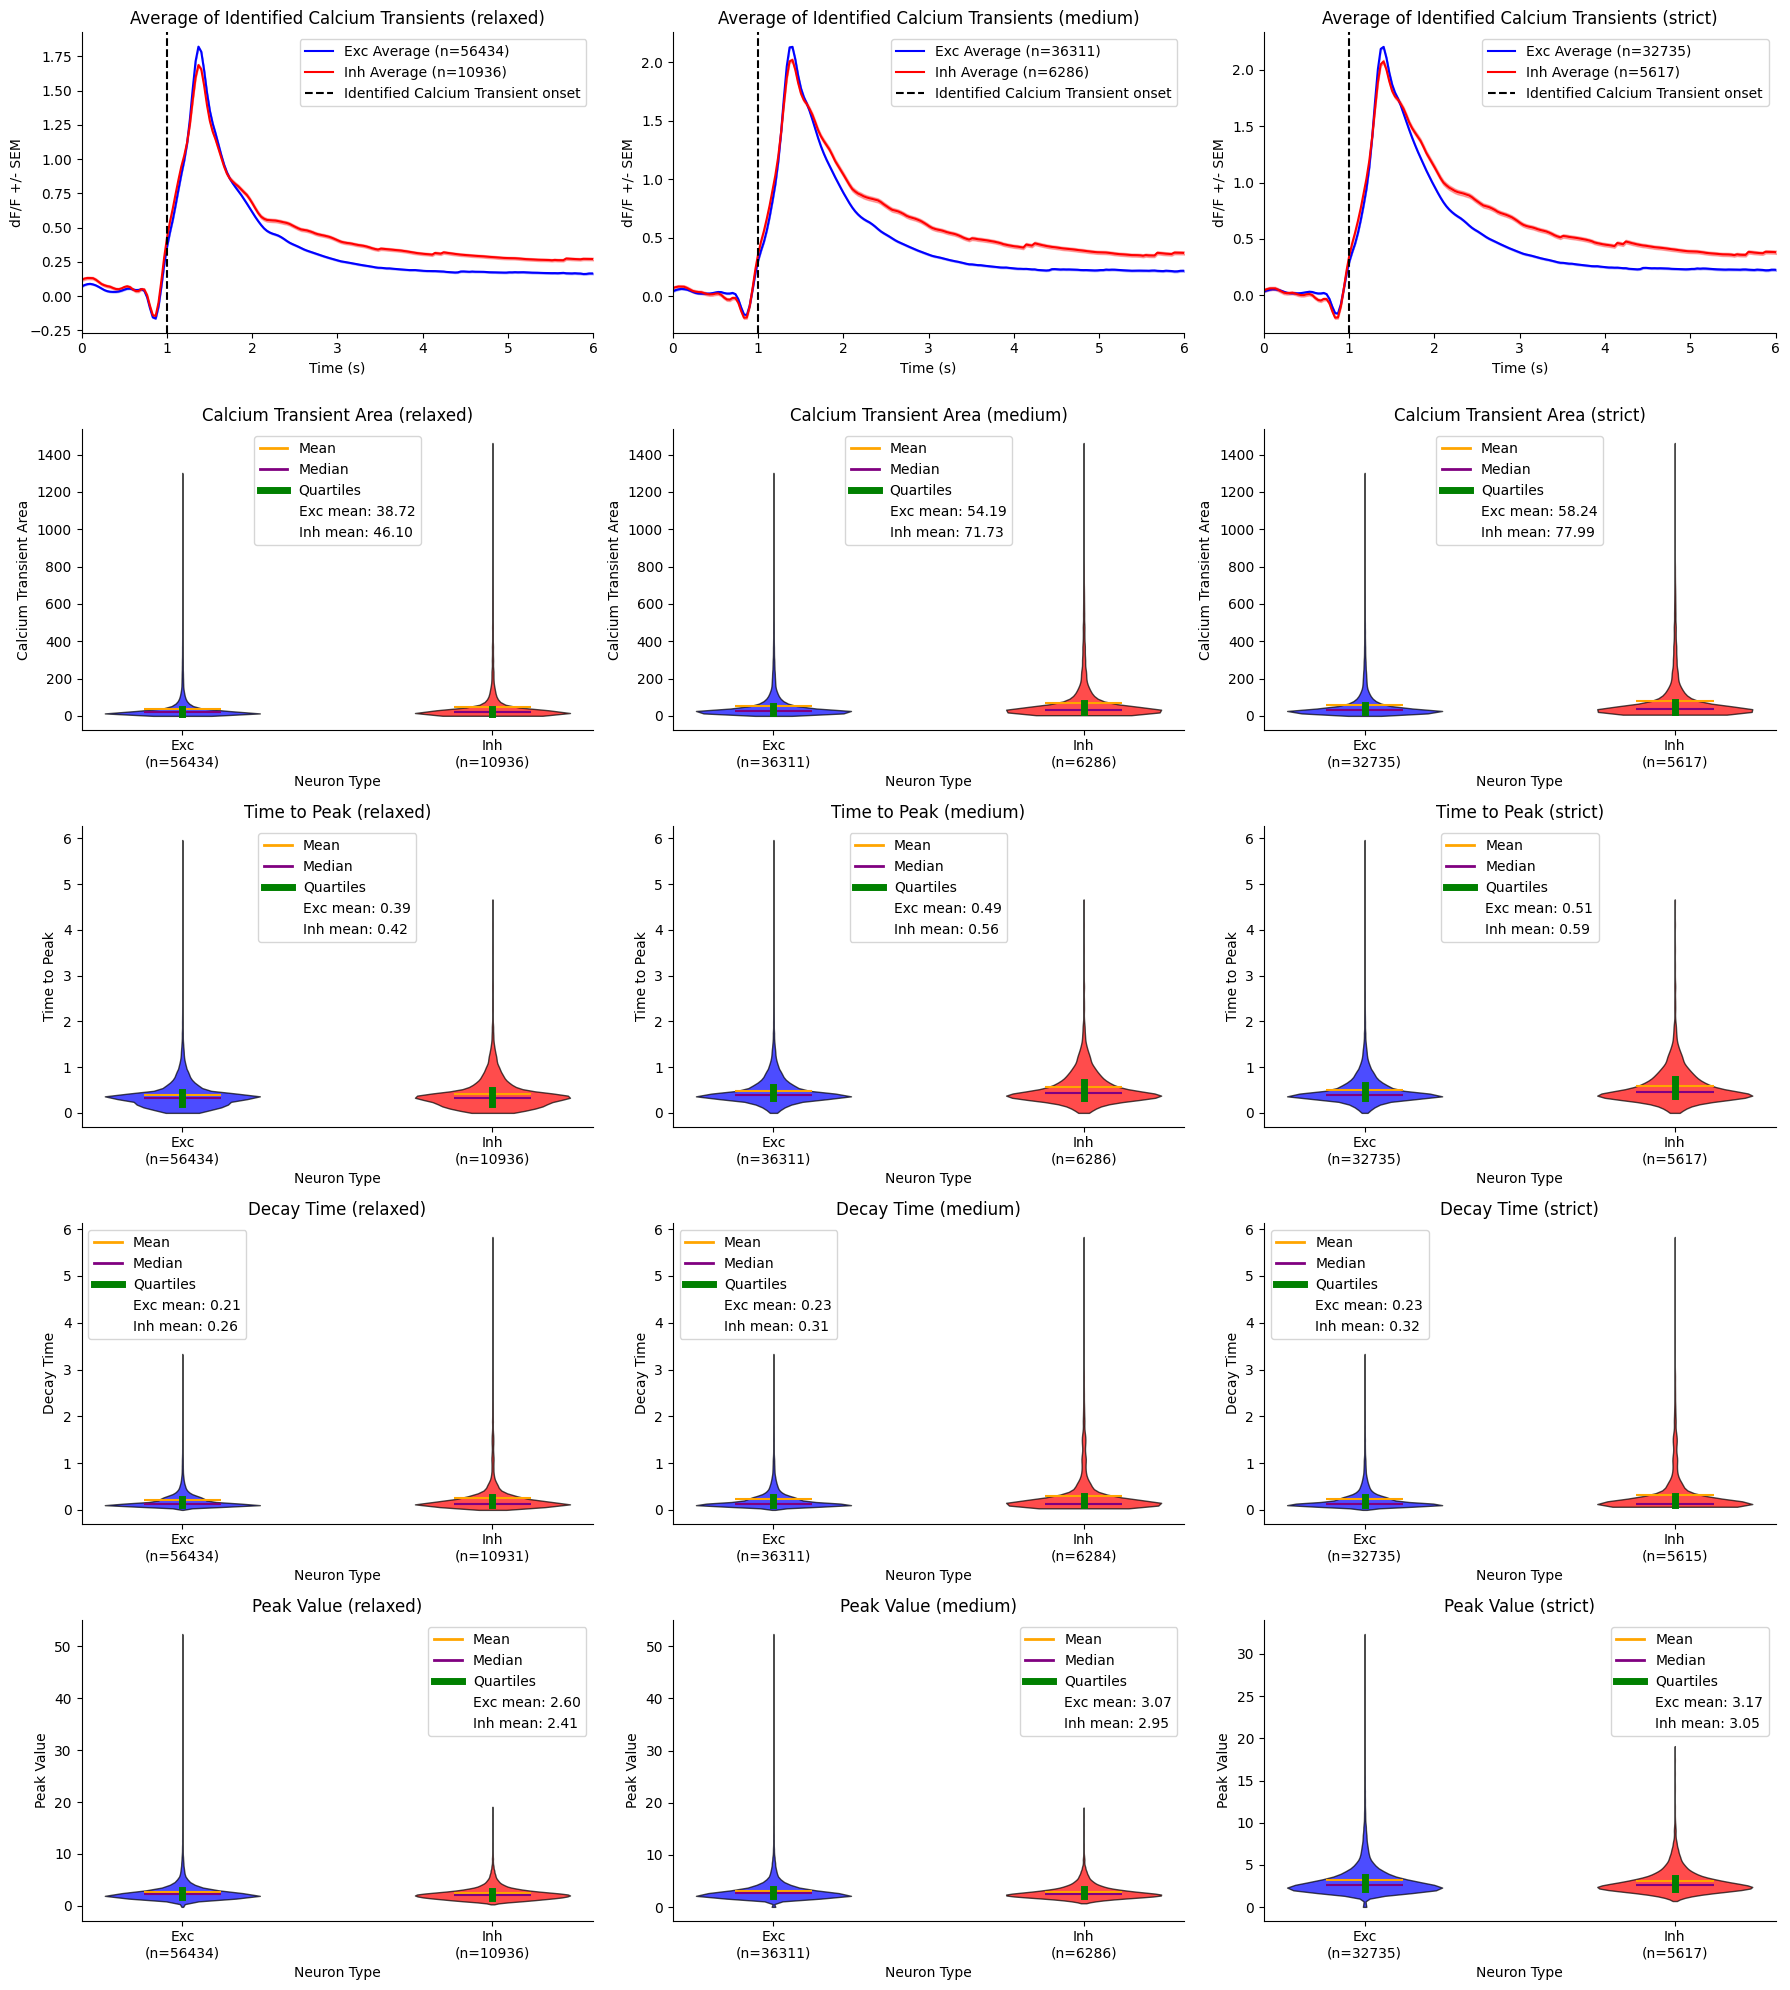

In [125]:
%matplotlib inline

# Helper function to create violin plot
def create_violin_plot(ax, exc_data, inh_data, ylabel, filter_type):
    # Remove NaN values
    exc_data = np.array(exc_data)
    inh_data = np.array(inh_data)
    exc_data = exc_data[~np.isnan(exc_data)]
    inh_data = inh_data[~np.isnan(inh_data)]
    
    # Check if we have any valid data
    if len(exc_data) == 0 or len(inh_data) == 0:
        ax.text(0.5, 0.5, 'No valid data available', 
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        ax.set_title(f'{ylabel} ({filter_type})')
        return
    
    # Calculate mean values
    exc_mean = np.mean(exc_data)
    inh_mean = np.mean(inh_data)
    
    # Create violin plot
    parts = ax.violinplot([exc_data, inh_data], showmeans=True, showmedians=True, showextrema=False)
    
    # Customize violin plot colors
    for pc in parts['bodies']:
        pc.set_facecolor('blue' if pc.get_paths()[0].vertices[0][0] < 1.5 else 'red')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    parts['cmeans'].set_color('orange')
    parts['cmedians'].set_color('purple')
    
    # Adding box for quartiles
    for j, data in enumerate([exc_data, inh_data]):
        q1, q3 = np.percentile(data, [25, 75])
        ax.plot([j + 1, j + 1], [q1, q3], color='green', lw=5)
    
    # Create x-tick labels with counts
    x_labels = [f'Exc\n(n={len(exc_data)})', f'Inh\n(n={len(inh_data)})']
    ax.set_xticks([1, 2])
    ax.set_xticklabels(x_labels)
    
    ax.set_xlabel('Neuron Type')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} ({filter_type})')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adding legend with mean values
    handles = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Mean'),
        plt.Line2D([0], [0], color='purple', lw=2, label='Median'),
        plt.Line2D([0], [0], color='green', lw=5, label='Quartiles'),
        plt.Line2D([0], [0], color='blue', lw=0, label=f'Exc mean: {exc_mean:.2f}'),
        plt.Line2D([0], [0], color='red', lw=0, label=f'Inh mean: {inh_mean:.2f}')
    ]
    ax.legend(handles=handles)

    
# Helper function to pad arrays with NaN to make them homogeneous
def pad_with_nan(arrays):
    max_length = max(map(len, arrays))
    return np.array([np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in arrays])

# Helper function to calculate SEM
def calculate_sem(data):
    return np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))

# Initialize lists to store pooled data for excitatory and inhibitory neurons
Exc_all_segments = {'strict': [], 'medium': [], 'relaxed': []}
Inh_all_segments = {'strict': [], 'medium': [], 'relaxed': []}

# Iterate through the results and pool the data for each neuron type
for neuron_index in results.keys():
    if labels_main[neuron_index] == -1:  # Excitatory neurons
        for filter_type in ['strict', 'medium', 'relaxed']:
            Exc_all_segments[filter_type].extend(results[neuron_index][f'{filter_type}_aligned_segments'])
    elif labels_main[neuron_index] == 1:  # Inhibitory neurons
        for filter_type in ['strict', 'medium', 'relaxed']:
            Inh_all_segments[filter_type].extend(results[neuron_index][f'{filter_type}_aligned_segments'])

# Create the figure with 5x3 subplots
fig, axs = plt.subplots(5, 3, figsize=(18, 20))

filter_types = ['relaxed', 'medium', 'strict']

for i, filter_type in enumerate(filter_types):
    # Pad segments with NaN to make them homogeneous
    Exc_segments_padded = pad_with_nan(Exc_all_segments[filter_type])
    Inh_segments_padded = pad_with_nan(Inh_all_segments[filter_type])
    
    # Calculate average and SEM
    Exc_average = np.nanmean(Exc_segments_padded, axis=0)
    Exc_sem = calculate_sem(Exc_segments_padded)
    Inh_average = np.nanmean(Inh_segments_padded, axis=0)
    Inh_sem = calculate_sem(Inh_segments_padded)
    
    # Time array
    time_array_exc = np.linspace(0, Exc_average.shape[0] / 30, Exc_average.shape[0])
    time_array_inh = np.linspace(0, Inh_average.shape[0] / 30, Inh_average.shape[0])
    
    # Plot average and SEM for excitatory neurons
    axs[0, i].plot(time_array_exc, Exc_average, color='blue', label=f'Exc Average (n={len(Exc_all_segments[filter_type])})')
    axs[0, i].fill_between(time_array_exc, Exc_average - Exc_sem, Exc_average + Exc_sem, color='blue', alpha=0.3)
    
    # Plot average and SEM for inhibitory neurons
    axs[0, i].plot(time_array_inh, Inh_average, color='red', label=f'Inh Average (n={len(Inh_all_segments[filter_type])})')
    axs[0, i].fill_between(time_array_inh, Inh_average - Inh_sem, Inh_average + Inh_sem, color='red', alpha=0.3)
    
    # Add black dashed line at left_frames/30
    axs[0, i].axvline(x=left_frames/30, color='k', linestyle='--', label='Identified Calcium Transient onset')
    
    # Limit x-axis to 6 seconds
    axs[0, i].set_xlim([0, 6])
    
    # Add labels and title
    axs[0, i].set_title(f'Average of Identified Calcium Transients ({filter_type})')
    axs[0, i].set_xlabel('Time (s)')
    axs[0, i].set_ylabel('dF/F +/- SEM')
    axs[0, i].legend()
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)

# Plot violin plots for all rows
for i, filter_type in enumerate(filter_types):
    # Area plots (second row)
    if filter_type == 'strict':
        Exc_areas = [area for neuron_areas in Exc_all_areas_strict for area in neuron_areas]
        Inh_areas = [area for neuron_areas in Inh_all_areas_strict for area in neuron_areas]
        
        Exc_time_peaks = [tp for neuron_tp in Exc_all_time_peak_segments_strict for tp in neuron_tp]
        Inh_time_peaks = [tp for neuron_tp in Inh_all_time_peak_segments_strict for tp in neuron_tp]
        
        Exc_decay = [d for neuron_d in Exc_all_decay_times_strict for d in neuron_d]
        Inh_decay = [d for neuron_d in Inh_all_decay_times_strict for d in neuron_d]
        
        Exc_peaks = [p for neuron_p in Exc_all_peaks_strict for p in neuron_p]
        Inh_peaks = [p for neuron_p in Inh_all_peaks_strict for p in neuron_p]
        
    elif filter_type == 'medium':
        Exc_areas = [area for neuron_areas in Exc_all_areas_medium for area in neuron_areas]
        Inh_areas = [area for neuron_areas in Inh_all_areas_medium for area in neuron_areas]
        
        Exc_time_peaks = [tp for neuron_tp in Exc_all_time_peak_segments_medium for tp in neuron_tp]
        Inh_time_peaks = [tp for neuron_tp in Inh_all_time_peak_segments_medium for tp in neuron_tp]
        
        Exc_decay = [d for neuron_d in Exc_all_decay_times_medium for d in neuron_d]
        Inh_decay = [d for neuron_d in Inh_all_decay_times_medium for d in neuron_d]
        
        Exc_peaks = [p for neuron_p in Exc_all_peaks_medium for p in neuron_p]
        Inh_peaks = [p for neuron_p in Inh_all_peaks_medium for p in neuron_p]
        
    else:  # relaxed
        Exc_areas = [area for neuron_areas in Exc_all_areas_relaxed for area in neuron_areas]
        Inh_areas = [area for neuron_areas in Inh_all_areas_relaxed for area in neuron_areas]
        
        Exc_time_peaks = [tp for neuron_tp in Exc_all_time_peak_segments_relaxed for tp in neuron_tp]
        Inh_time_peaks = [tp for neuron_tp in Inh_all_time_peak_segments_relaxed for tp in neuron_tp]
        
        Exc_decay = [d for neuron_d in Exc_all_decay_times_relaxed for d in neuron_d]
        Inh_decay = [d for neuron_d in Inh_all_decay_times_relaxed for d in neuron_d]
        
        Exc_peaks = [p for neuron_p in Exc_all_peaks_relaxed for p in neuron_p]
        Inh_peaks = [p for neuron_p in Inh_all_peaks_relaxed for p in neuron_p]

    # Create violin plots for each metric
    create_violin_plot(axs[1, i], Exc_areas, Inh_areas, 'Calcium Transient Area', filter_type)
    create_violin_plot(axs[2, i], Exc_time_peaks, Inh_time_peaks, 'Time to Peak', filter_type)
    create_violin_plot(axs[3, i], Exc_decay, Inh_decay, 'Decay Time', filter_type)
    create_violin_plot(axs[4, i], Exc_peaks, Inh_peaks, 'Peak Value', filter_type)
    
plt.tight_layout()
plt.show()

In [126]:
fig.savefig('Pooled_Calcium_Transient_Analysis.pdf', bbox_inches='tight')

## Anlaysis of inh/exc neurons Grand_average


In [78]:
Exc_average_all_strict = []
Exc_std_all_strict = []
Exc_peak_all_strict = []
Exc_peak_time_all_strict = []
Exc_area_all_strict = []
Exc_half_decay_all_strict = []

Exc_average_all_medium = []
Exc_std_all_medium = []
Exc_peak_all_medium = []
Exc_peak_time_all_medium = []
Exc_area_all_medium = []
Exc_half_decay_all_medium = []

Exc_average_all_relaxed = []
Exc_std_all_relaxed = []
Exc_peak_all_relaxed = []
Exc_peak_time_all_relaxed = []
Exc_area_all_relaxed = []
Exc_half_decay_all_relaxed = []

Inh_average_all_strict = []
Inh_std_all_strict = []
Inh_peak_all_strict = []
Inh_peak_time_all_strict = []
Inh_area_all_strict = []
Inh_half_decay_all_strict = []

Inh_average_all_medium = []
Inh_std_all_medium = []
Inh_peak_all_medium = []
Inh_peak_time_all_medium = []
Inh_area_all_medium = []
Inh_half_decay_all_medium = []

Inh_average_all_relaxed = []
Inh_std_all_relaxed = []
Inh_peak_all_relaxed = []
Inh_peak_time_all_relaxed = []
Inh_area_all_relaxed = []
Inh_half_decay_all_relaxed = []

for neuron_index in results.keys():
    if labels_main[neuron_index] == -1:
        Exc_average_all_strict.append(results[neuron_index]['strict_average_segment'])
        Exc_std_all_strict.append(results[neuron_index]['strict_std_segment'])
        Exc_peak_all_strict.append(results[neuron_index]['strict_peak_segment'])
        Exc_peak_time_all_strict.append(results[neuron_index]['strict_time_peak_segment'])
        Exc_area_all_strict.append(np.sum(results[neuron_index]['strict_area_segments']))
        Exc_half_decay_all_strict.append(results[neuron_index]['strict_half_decay'])

        Exc_average_all_medium.append(results[neuron_index]['medium_average_segment'])
        Exc_std_all_medium.append(results[neuron_index]['medium_std_segment'])
        Exc_peak_all_medium.append(results[neuron_index]['medium_peak_segment'])
        Exc_peak_time_all_medium.append(results[neuron_index]['medium_time_peak_segment'])
        Exc_area_all_medium.append(np.sum(results[neuron_index]['medium_area_segments']))
        Exc_half_decay_all_medium.append(results[neuron_index]['medium_half_decay'])

        Exc_average_all_relaxed.append(results[neuron_index]['relaxed_average_segment'])
        Exc_std_all_relaxed.append(results[neuron_index]['relaxed_std_segment'])
        Exc_peak_all_relaxed.append(results[neuron_index]['relaxed_peak_segment'])
        Exc_peak_time_all_relaxed.append(results[neuron_index]['relaxed_time_peak_segment'])
        Exc_area_all_relaxed.append(np.sum(results[neuron_index]['relaxed_area_segments']))
        Exc_half_decay_all_relaxed.append(results[neuron_index]['relaxed_half_decay'])
    elif labels_main[neuron_index] == 1:
        Inh_average_all_strict.append(results[neuron_index]['strict_average_segment'])
        Inh_std_all_strict.append(results[neuron_index]['strict_std_segment'])
        Inh_peak_all_strict.append(results[neuron_index]['strict_peak_segment'])
        Inh_peak_time_all_strict.append(results[neuron_index]['strict_time_peak_segment'])
        Inh_area_all_strict.append(np.sum(results[neuron_index]['strict_area_segments']))
        Inh_half_decay_all_strict.append(results[neuron_index]['strict_half_decay'])

        Inh_average_all_medium.append(results[neuron_index]['medium_average_segment'])
        Inh_std_all_medium.append(results[neuron_index]['medium_std_segment'])
        Inh_peak_all_medium.append(results[neuron_index]['medium_peak_segment'])
        Inh_peak_time_all_medium.append(results[neuron_index]['medium_time_peak_segment'])
        Inh_area_all_medium.append(np.sum(results[neuron_index]['medium_area_segments']))
        Inh_half_decay_all_medium.append(results[neuron_index]['medium_half_decay'])

        Inh_average_all_relaxed.append(results[neuron_index]['relaxed_average_segment'])
        Inh_std_all_relaxed.append(results[neuron_index]['relaxed_std_segment'])
        Inh_peak_all_relaxed.append(results[neuron_index]['relaxed_peak_segment'])
        Inh_peak_time_all_relaxed.append(results[neuron_index]['relaxed_time_peak_segment'])
        Inh_area_all_relaxed.append(np.sum(results[neuron_index]['relaxed_area_segments']))
        Inh_half_decay_all_relaxed.append(results[neuron_index]['relaxed_half_decay'])

C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_19980\46150209.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_area = axs[1, i].boxplot([Exc_area, Inh_area], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_19980\46150209.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_peak_time = axs[2, i].boxplot([Exc_peak_time, Inh_peak_time], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_19980\46150209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_peak = axs[3, i].boxp

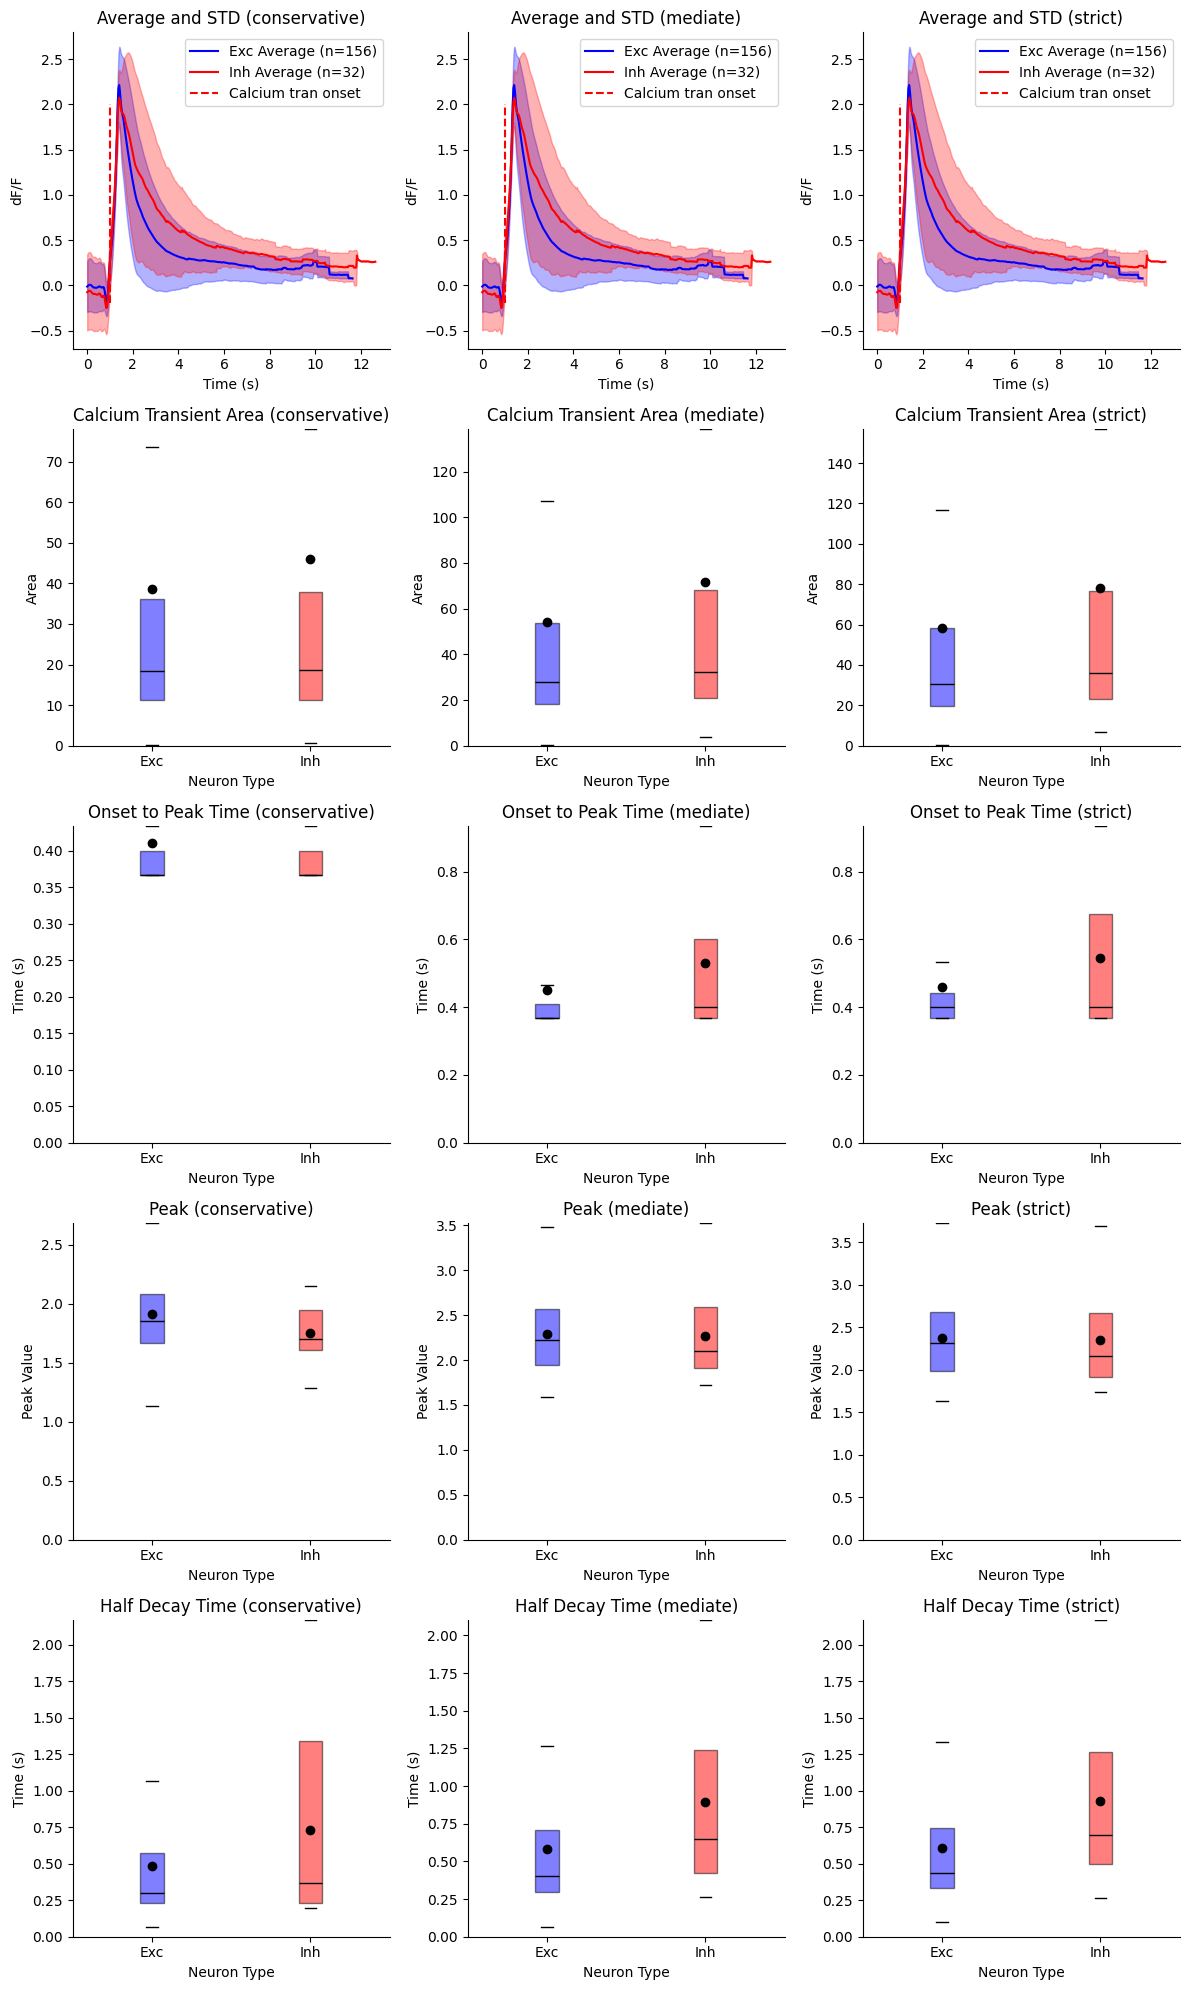

In [ ]:
%matplotlib inline

# Helper function to calculate axis limits ignoring outliers
def get_y_limits(data):
    q1, q3 = np.percentile(data, [25, 75])  # Calculate the first and third quartiles
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = [d for d in data if lower_bound <= d <= upper_bound]  # Remove outliers
    return min(filtered_data), max(filtered_data)

filter_types = ['relaxed', 'medium', 'strict']

fig, axs = plt.subplots(5, len(filter_types), figsize=(12, 20))

for i, filter_type in enumerate(filter_types):
    # Extract data for excitatory neurons
    Exc_average = np.nanmean([np.pad(arr, (0, max(map(len, Exc_average_all_strict)) - len(arr)), constant_values=np.nan) for arr in Exc_average_all_strict], axis=0)
    Exc_std = np.nanstd([np.pad(arr, (0, max(map(len, Exc_average_all_strict)) - len(arr)), constant_values=np.nan) for arr in Exc_average_all_strict], axis=0)
    Exc_area = [area for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == -1 for area in results[neuron_index][f'{filter_type}_area_segments']]
    Exc_peak_time = [results[neuron_index][f'{filter_type}_time_peak_segment'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == -1]
    Exc_peak = [results[neuron_index][f'{filter_type}_peak_segment'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == -1]
    Exc_half_decay = [results[neuron_index][f'{filter_type}_half_decay'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == -1]

    # Extract data for inhibitory neurons
    Inh_average = np.nanmean([np.pad(arr, (0, max(map(len, Inh_average_all_strict)) - len(arr)), constant_values=np.nan) for arr in Inh_average_all_strict], axis=0)
    Inh_std = np.nanstd([np.pad(arr, (0, max(map(len, Inh_average_all_strict)) - len(arr)), constant_values=np.nan) for arr in Inh_average_all_strict], axis=0)
    Inh_area = [area for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == 1 for area in results[neuron_index][f'{filter_type}_area_segments']]
    Inh_peak_time = [results[neuron_index][f'{filter_type}_time_peak_segment'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == 1]
    Inh_peak = [results[neuron_index][f'{filter_type}_peak_segment'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == 1]
    Inh_half_decay = [results[neuron_index][f'{filter_type}_half_decay'] for neuron_index in range(len(labels_main)) if labels_main[neuron_index] == 1]

    # Time arrays
    time_exc = np.linspace(0, Exc_average.shape[0]/30, Exc_average.shape[0])
    time_inh = np.linspace(0, Inh_average.shape[0]/30, Inh_average.shape[0])

    # Plot average and std
    axs[0, i].plot(time_exc, Exc_average, color='blue', label=f'Exc Average (n={len(Exc_average_all_strict)})')
    axs[0, i].fill_between(time_exc, Exc_average - Exc_std, Exc_average + Exc_std, color='blue', alpha=0.3)
    axs[0, i].plot(time_inh, Inh_average, color='red', label=f'Inh Average (n={len(Inh_average_all_strict)})')
    axs[0, i].fill_between(time_inh, Inh_average - Inh_std, Inh_average + Inh_std, color='red', alpha=0.3)
    axs[0, i].vlines(x=left_frames/30, ymin=-0.2, ymax=2, color='r', linestyle='--', label='Calcium tran onset')
    axs[0, i].set_title(f'Average and STD ({filter_type})')
    axs[0, i].set_xlabel('Time (s)')
    axs[0, i].set_ylabel('dF/F')
    axs[0, i].legend()
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)

    # Plot box plot for area
    bp_area = axs[1, i].boxplot([Exc_area, Inh_area], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
                                medianprops=dict(color='black'),
                                meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black'),
                                whiskerprops=dict(visible=False),
                                flierprops=dict(visible=False))

    # Set colors for Exc and Inh
    colors = ['blue', 'red']
    for patch, color in zip(bp_area['boxes'], colors):
        patch.set(facecolor=color, alpha=0.5)

    axs[1, i].set_title(f'Calcium Transient Area ({filter_type})')
    axs[1, i].set_xlabel('Neuron Type')
    axs[1, i].set_ylabel('Area')
    axs[1, i].spines['top'].set_visible(False)
    axs[1, i].spines['right'].set_visible(False)
    
    # Manually adjust y-axis limits
    exc_min, exc_max = get_y_limits(Exc_area)
    inh_min, inh_max = get_y_limits(Inh_area)
    axs[1, i].set_ylim(0, max(exc_max, inh_max))

    # Repeat the same process for other boxplots

    # Plot box plot for peak time
    bp_peak_time = axs[2, i].boxplot([Exc_peak_time, Inh_peak_time], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
                                    medianprops=dict(color='black'),
                                    meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black'),
                                    whiskerprops=dict(visible=False),
                                    flierprops=dict(visible=False))

    # Set colors for Exc and Inh
    for patch, color in zip(bp_peak_time['boxes'], colors):
        patch.set(facecolor=color, alpha=0.5)

    axs[2, i].set_title(f'Onset to Peak Time ({filter_type})')
    axs[2, i].set_xlabel('Neuron Type')
    axs[2, i].set_ylabel('Time (s)')
    axs[2, i].spines['top'].set_visible(False)
    axs[2, i].spines['right'].set_visible(False)
    
    exc_min, exc_max = get_y_limits(Exc_peak_time)
    inh_min, inh_max = get_y_limits(Inh_peak_time)
    axs[2, i].set_ylim(0, max(exc_max, inh_max))

    # Plot box plot for peak
    bp_peak = axs[3, i].boxplot([Exc_peak, Inh_peak], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
                                medianprops=dict(color='black'),
                                meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black'),
                                whiskerprops=dict(visible=False),
                                flierprops=dict(visible=False))

    # Set colors for Exc and Inh
    for patch, color in zip(bp_peak['boxes'], colors):
        patch.set(facecolor=color, alpha=0.5)

    axs[3, i].set_title(f'Peak ({filter_type})')
    axs[3, i].set_xlabel('Neuron Type')
    axs[3, i].set_ylabel('Peak Value')
    axs[3, i].spines['top'].set_visible(False)
    axs[3, i].spines['right'].set_visible(False)
    
    exc_min, exc_max = get_y_limits(Exc_peak)
    inh_min, inh_max = get_y_limits(Inh_peak)
    axs[3, i].set_ylim(0, max(exc_max, inh_max))

    # Plot box plot for half decay time
    bp_half_decay = axs[4, i].boxplot([Exc_half_decay, Inh_half_decay], vert=True, patch_artist=True, showmeans=True, labels=['Exc', 'Inh'],
                                    medianprops=dict(color='black'),
                                    meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black'),
                                    whiskerprops=dict(visible=False),
                                    flierprops=dict(visible=False))

    # Set colors for Exc and Inh
    for patch, color in zip(bp_half_decay['boxes'], colors):
        patch.set(facecolor=color, alpha=0.5)

    axs[4, i].set_title(f'Half Decay Time ({filter_type})')
    axs[4, i].set_xlabel('Neuron Type')
    axs[4, i].set_ylabel('Time (s)')
    axs[4, i].spines['top'].set_visible(False)
    axs[4, i].spines['right'].set_visible(False)
    
    exc_min, exc_max = get_y_limits(Exc_half_decay)
    inh_min, inh_max = get_y_limits(Inh_half_decay)
    axs[4, i].set_ylim(0, max(exc_max, inh_max))
    
    
plt.tight_layout()
plt.show()

In [86]:
# save figure as pdf

fig.savefig('calcium_transient_analysis_over_neurons.pdf', bbox_inches='tight')